In [230]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from ir_measures import RR, R, nDCG, read_trec_run
import ir_datasets
import gzip
import json
sns.set_theme()
import itertools
import numpy as np

In [231]:
from tqdm import tqdm
# qrels_dl19 = list(ir_datasets.load('msmarco-passage/trec-dl-2019').qrels)
# qrels_devs = list(ir_datasets.load('msmarco-passage/dev/small').qrels)
df = []
settings = []
for ncells in [1, 2, 4, 8]:
  for centroid_score_threshold in [0.3, 0.4, 0.45, 0.5, 0.6]:
    for ndocs in [256, 1024, 4096, 8192]:
        settings.append((
            f'plaid',
            f'plaid.ncells-{ncells}.cst-{centroid_score_threshold}.ndocs-{ndocs}',
            f'nprobe={ncells} tct={centroid_score_threshold} ndocs={ndocs}'
        ))
for n in [100, 200, 500, 1000, 2000, 5000, 10000]:
    settings.append((
        f'rerank',
        f'ladr.num_results-{n}.num_neighbours-0.num_hops-0',
        f'n={n}'
    ))
for n in [100, 500, 1000]:
    for nn in [64, 128]:
        for d in [10,20,50,100]:
            settings.append((
                f'ladr',
                f'ladr.num_results-{n}.num_neighbours-{nn}.depth-{d}',
                f'n={n} neighbours={nn} depth={d}'
            ))
for cls, id, setting in tqdm(settings):
    latency = float(open(f'results/devs.{id}.time').read())
    res_dl19 = json.load(gzip.open(f'results/dl19.{id}.run.gz.measures.json.gz'))
    res_devs = json.load(gzip.open(f'results/devs.{id}.run.gz.measures.json.gz'))
    df.append({
        'class': cls,
        'setting': setting,
        'devs_latency': latency,
        'dl19_ndcg10': res_dl19['avg']['nDCG@10'],
        'dl19_ndcg1k': res_dl19['avg']['nDCG@1000'],
        'dl19_r1k': res_dl19['avg']['R(rel=2)@1000'],
        'dl19_rbo99': res_dl19['avg']['RBO(p=0.9)'],
        'devs_rr10': res_devs['avg']['RR@10'],
        'devs_r1k': res_devs['avg']['R@1000'],
        'devs_rbo99': res_devs['avg']['RBO(p=0.9)'],
    })
df = pd.DataFrame(df)
dl19_exh = json.load(gzip.open('results/dl19.exhuastive.run.gz.measures.json.gz'))['avg']
devs_exh = json.load(gzip.open('results/devs.exhuastive.run.gz.measures.json.gz'))['avg']

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 111/111 [00:01<00:00, 96.09it/s]


In [240]:
def pareto(dataframe, x, y):
    # dataframe = dataframe.sort_values(by=[x, y], ascending=[True, True])
    # pareto_frontier = []
    # for index, row in dataframe.itertuples():
    #     if not any(point[y] >= row[y] for point in pareto_frontier):
    #         pareto_frontier.append(row.copy())
    # pareto_frontier = pd.DataFrame(pareto_frontier)
    # return pareto_frontier
    dataframe = dataframe.sort_values(by=[x, y], ascending=[True, True])
    costs = np.array(list(zip(dataframe[x], -dataframe[y])))
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient]<c, axis=1)  # Keep any point with a lower cost
            is_efficient[i] = True  # And keep self
    return dataframe.iloc[is_efficient]

In [241]:
pareto(df[df['class']==cls].copy(), x='devs_latency', y='dl19_ndcg1k')

,class,setting,devs_latency,dl19_ndcg10,dl19_ndcg1k,dl19_r1k,dl19_rbo99,devs_rr10,devs_r1k,devs_rbo99
87,ladr,n=100 neighbours=64 depth=10,23.140818,0.741953,0.685250,0.723439,0.876704,0.380525,0.852734,0.861680
95,ladr,n=500 neighbours=64 depth=10,32.516136,0.740856,0.732061,0.800832,0.914542,0.390423,0.906590,0.914692
88,ladr,n=100 neighbours=64 depth=20,44.139107,0.746007,0.736953,0.810943,0.890747,0.383489,0.883680,0.890617
96,ladr,n=500 neighbours=64 depth=20,45.529988,0.743593,0.758838,0.848649,0.924561,0.391678,0.922612,0.930658
104,ladr,n=1000 neighbours=64 depth=20,58.463473,0.742974,0.764823,0.862947,0.929026,0.393464,0.938133,0.943948
100,ladr,n=500 neighbours=128 depth=20,81.679774,0.742878,0.771867,0.872472,0.932579,0.393763,0.939458,0.942985
97,ladr,n=500 neighbours=64 depth=50,94.740147,0.743593,0.772130,0.879897,0.927159,0.393658,0.945427,0.945596
108,ladr,n=1000 neighbours=128 depth=20,96.426256,0.742833,0.772793,0.877769,0.935459,0.394587,0.949594,0.952362
98,ladr,n=500 neighbours=64 depth=100,177.157650,0.743470,0.772913,0.883599,0.931922,0.394214,0.956029,0.954529
109,ladr,n=1000 neighbours=128 depth=50,180.240174,0.742833,0.775939,0.888231,0.940388,0.395391,0.963945,0.963676


/tmp/ipykernel_3361182/1168506116.py:42: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  annot = ax.scatter([getattr(row, x)], [getattr(row, y)], 20, c=line.get_color(), edgecolors='k', zorder=1000, label='(nprobe, $t_{cs}$, ndocs)')


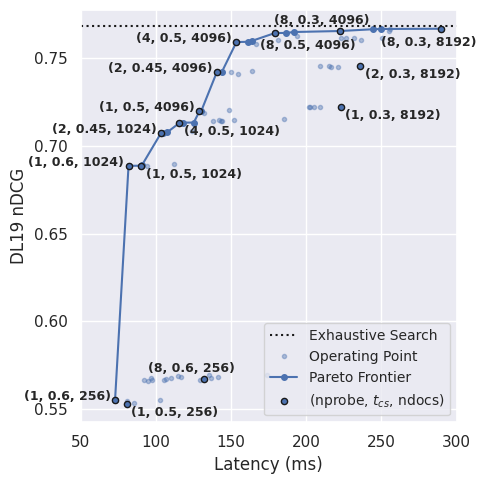

In [242]:
x='devs_latency'
for y in ['dl19_ndcg1k']:
    fig, ax = plt.subplots(figsize=(5,5))
    lines = {}
    for cls in ['plaid']:
        sub_df = df[df['class']==cls]
        line, = ax.plot(sub_df[x], sub_df[y], '.', alpha=0.4, label='Operating Point')
        p_df = pareto(sub_df.copy(), x=x, y=y)
        frontier, = ax.plot(p_df[x], p_df[y], '-o', markersize=4, label='Pareto Frontier', c=line.get_color())
        for i, row in enumerate(itertools.chain(
            p_df.itertuples(),
            df[(df['class']=='plaid') & (df['setting']=='nprobe=1 tct=0.5 ndocs=256')].itertuples(),
            df[(df['class']=='plaid') & (df['setting']=='nprobe=8 tct=0.6 ndocs=256')].itertuples(),
            df[(df['class']=='plaid') & (df['setting']=='nprobe=1 tct=0.3 ndocs=8192')].itertuples(),
            df[(df['class']=='plaid') & (df['setting']=='nprobe=2 tct=0.3 ndocs=8192')].itertuples(),
            )):
            pos = None
            if i in {2, 7, 18, 25, 27, 28}:
                pos = (3, -0.007, 'left')
            if i in {18}:
                pos = (-10, -0.009, 'left')
            if i in {0, 1, 4, 10, 13, 15}:
                pos = (-3, 0.0001, 'right')
            if i in {21, 26}:
                pos = (20, 0.004, 'right')
            if i in {24}:
                pos = (-40, -0.01, 'left')
            # if i in {11}:
            #     pos = (3, -0.0004, 'left')
            # if i in {16, 17, 18}:
            #     pos = (3, 0.0001, 'left')
            # if i in {15}:
            #     pos = (3, -0.0003, 'left')
            
            # if i in {3, 5}:
            #     pos = (-3, 0.0001, 'right')
            # if i in {7}:
            #     pos = (-3, -0.0001, 'right')
            if pos:
                args = '(' + ', '.join([r.split('=')[1] for r in row.setting.split()]) + ')'
                ax.annotate(args, (getattr(row, x)+pos[0], getattr(row, y)+pos[1]), fontsize=9, ha=pos[2], weight='bold')
                annot = ax.scatter([getattr(row, x)], [getattr(row, y)], 20, c=line.get_color(), edgecolors='k', zorder=1000, label='(nprobe, $t_{cs}$, ndocs)')
        lines[cls] = line
    # sub_df = df[df.setting.isin(['nprobe=1 tct=0.5 ndocs=256', 'nprobe=2 tct=0.45 ndocs=1024', 'nprobe=4 tct=0.4 ndocs=4096'])]
    # rec, = ax.plot(sub_df[x], sub_df[y], '*', label='  paper', c='#FFD700')
    ax.set_xlim(50, 300)
    ax.set_xlabel('Latency (ms)')
    ax.set_ylabel({
        'dl19_ndcg1k': 'DL19 nDCG',
        'dl19_ndcg10': 'DL19 nDCG@10',
        'dl19_rr3': 'DL19 RR(rel=3)',
        'dl19_r1k': 'DL19 R@1k',
        'devs_rr10': 'MS MARCO Dev RR@10',
    }.get(y, y))
    exh = {
        'dl19_ndcg1k': dl19_exh['nDCG@1000'],
        'dl19_ndcg10': dl19_exh['nDCG@10'],
        'dl19_r1k': dl19_exh['R(rel=2)@1000'],
        'devs_rr10': devs_exh['RR@10'],
        'devs_r1k': devs_exh['R@1000'],
        'devs_rbo99': devs_exh['RBO(p=0.99)'],
    }[y]
    exh = ax.axhline(exh, ls=':', c='k', label='Exhaustive Search')
    # ax.legend(handles=[lines['plaid'], rec, lines['rerank'], lines['ladr']])
    from matplotlib.patches import Patch
    patch = Patch(facecolor='#0000', edgecolor='#0000', )
    ax.legend(handles=[exh, line, frontier, annot], loc='lower right', fontsize=10)
    plt.tight_layout()
    plt.savefig('plaid_pareto.pdf')

In [138]:
df[(df['class']=='plaid') & (df['setting']=='nprobe=4 tct=0.75 ndocs=1024')]

,class,setting,devs_latency,dl19_ndcg10,dl19_ndcg1k,dl19_r1k,dl19_rbo99,devs_rr10,devs_r1k,devs_rbo99
31,plaid,nprobe=2 tct=0.75 ndocs=8192,201.491217,0.745535,0.728283,0.825779,0.995432,0.395637,0.96632,0.984192


In [224]:
df[(df['class']=='plaid')&(df.devs_latency>225)&(df.dl19_ndcg1k<0.75)]

,class,setting,devs_latency,dl19_ndcg10,dl19_ndcg1k,dl19_r1k,dl19_rbo99,devs_rr10,devs_r1k,devs_rbo99
23,plaid,nprobe=2 tct=0.3 ndocs=8192,235.827164,0.744548,0.745781,0.844565,0.99881,0.397306,0.976516,0.995348
